In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

<figure>
  <IMG SRC="https://www.colorado.edu/cs/profiles/express/themes/cuspirit/logo.png" WIDTH=50 ALIGN="right">
</figure>
# Bootstrap Overview
*CSCI 3022 - Dirk Grunwald*

We often need to estimate parameters of a model that has some degree of uncertainity typically due to measurement error. Alternatively, we need to compare two models while addressing uncertainity. A _confidence interval_ is a method for communicating uncertainity. A common statement of a confidence interval might be 
>"The mean height of a white male in the US is 178cm with a 95% confidence interval of 6cm".

In essance, this is stating that if 100 people measured the height of men, 95 would find the estimated mean to be within 175 to 181 cm. We will explore confidence intervals in more detail later, but right now, lets look at one way of computing confidence intervals: the _bootstrap_

A statement such as "178cm with a 95% CI of 5cm" could be written as

$$ P\left[ |\bar x - 178| \geq 3 \right] \leq 0.95 $$

If we are modeling height using a _parametric model_ or assuming height follows a mathematical distribution such as the normal distribution, we would use the normal distribution to directly determine the probability of this occuring given the measured mean and standard deviation.

If the model is _non-parametric_ including possibly a empirical distribution, we could still estimate a confidence interval using the _bootstrap_ or other _resampling methods_.

## The Bootstrap and Resamping Methods

We'll first consider the _bootstrap_ because it provides an operational definition of a confidence interval -- in otherwords, it mimics the intuition that a confidence interval captures the distribution of values from multiple measurements of the sample population.

We'll start with a practical example, based on Simon Newcomb's 1882 data on the speed of light; more precisely, the time it takes light to travel 7442 meters at sea level. The currently accepted estimate of the speed of light under these conditions corresponds to a measurement of 24833.02 nanoseconds.

In [2]:
sol =  24800 + np.array([28, 26, 33, 24, 34, -44, 27, 16, 40, -2, 29, 22, 24, 21, 25, 30, 23, 29, 31, 19, 24, 20, 36, 32, 36, 28, 25, 21, 28, 29, 37, 25, 28, 26, 30, 32, 36, 26, 30, 22, 36, 23, 27, 27, 28, 27, 31, 27, 26, 33, 26, 32, 32, 24, 39, 28, 24, 25, 32, 25, 29, 27, 28, 29, 16, 23 ])

In [3]:
print('Estimated speed of light is ', np.mean(sol), 'ns per 7442m')
print('Or ', 7442 / (np.mean(sol) / 1000**3), 'm/s')
print('Standard speed of light is ', 7442 / (24833.02 / 1000**3), 'm/s')

Estimated speed of light is  24826.2121212 ns per 7442m
Or  299763812.686 m/s
Standard speed of light is  299681633.56692016 m/s


Let's look at the distribution of the measured data using a kernel density estimate plot, which is like a smoothed histogram:

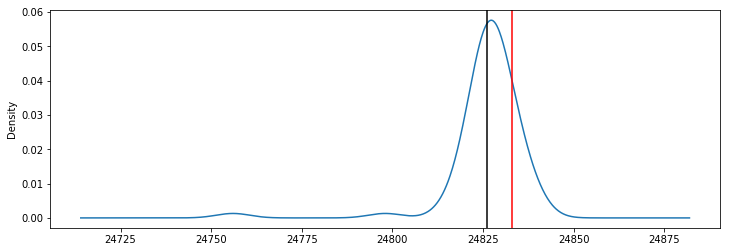

In [4]:
ssol = pd.Series(sol)
plt.figure(figsize=(12,4))
ssol.plot.kde()
plt.axvline(x=np.mean(sol),color='black')
plt.axvline(x=24833.02,color='r');

The black bar indicates the sample mean of the measured values and the red bar indicates the commonly accepted "true" value.

The mean shown is a single estimate of the speed of light, corresponding to the sample mean of all the data.

We want to calculate $s=E[S]$ and then determine $l$ and $u$ such that $P\left[ l \leq s\right] = 0.025$ and $P\left[ s \leq u\right] = 0.975$, _i.e._ the range [l,u] which would contain $s$ in 95% of experiments. 

To calculate a bootstrap confidence interval, we would use the following algorithm:

```python
means = []
for a long time:
   sample = random sample from data with replacement
   means = means + mean(sample)
report the range containing 95% of the sample means
```

It's easy to realize this in Python.

Given a `numpy` vector, we can draw a sample of `n` items using the `np.random.choice` function.

In [5]:
np.random.choice(sol, 5)

array([24825, 24829, 24816, 24827, 24821])

Then, we can extract the 2.5% and 97.5% percentile values from a `numpy` vector like this:

In [6]:
np.percentile(sol,[2.5, 97.5])

array([ 24809.25,  24837.75])

Now, let's wrap it all together. We will sample with replacement from the measurements 1000 times, compute the mean and then report the range containing 95% of the samples

In [7]:
means = ( [ np.mean( np.random.choice(sol, sol.size) ) for x in range(1000) ] )
print ('We have', len(means), 'means, some of which are ', means[:3])

We have 1000 means, some of which are  [24827.848484848484, 24826.651515151516, 24826.636363636364]


In [8]:
solrange = np.percentile(means, [2.5, 97.5])
print('Speed has mean', np.mean(sol), 'with lower CI', solrange[0], 'and upper CI', solrange[1])
print('CI is not symmetrical: lower', np.mean(sol)-solrange[0], 'upper', solrange[1]-np.mean(sol))

Speed has mean 24826.2121212 with lower CI 24823.4390152 and upper CI 24828.3636364
CI is not symmetrical: lower 2.77310606061 upper 2.15151515152


Let's understand what our result means by refering to our plot of the original data, the (single) sample mean and the 95% confidence interval

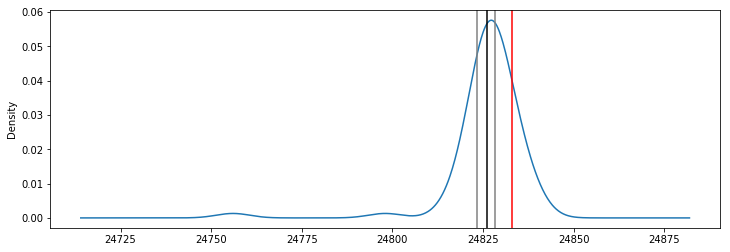

In [9]:
plt.figure(figsize=(12,4))
ssol.plot.kde()
plt.axvline(x=np.mean(sol),color='black')
plt.axvline(x=solrange[0],color='gray')
plt.axvline(x=solrange[1],color='gray')
plt.axvline(x=24833.02,color='r');

The 95% confidence interval brackets the sample mean, and we would expect 95% of repeated measurements by others using the same techniques and technology to (likley) be within the same range. The 95% confidence interval does not contain the "true mean" which is determined by different techniques and presumably better technology.

Any one sample from the data may have a wildly different estimate of the mean, but the confidence interval of the bootstrap becomes more narrow as we repeat the sampling process. We can visualize this for the first 100 samplings of the data using the compact but very arcane code below.

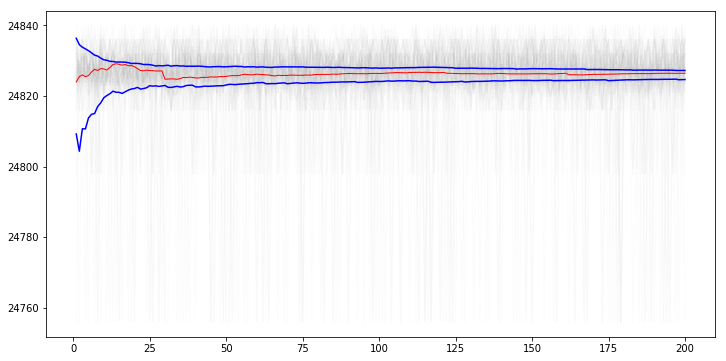

In [10]:
reps = sol.size
n = 200
solsamples = np.random.choice(sol, (n, reps), replace=True)
solmeans= 1/np.arange(1, n+1)[:, None] * np.cumsum(solsamples, axis=0)
upper, lower = np.percentile(solmeans, [2.5, 97.5], axis=1)
plt.figure(figsize=(12,6))
plt.plot(np.arange(1, n+1).reshape(n,1), solsamples, c='grey', alpha=0.02)
plt.plot(np.arange(1, n+1), solmeans[:, 0], c='red', linewidth=1)
plt.plot(np.arange(1, n+1), upper, 'b', np.arange(1, n+1), lower, 'b');

The gray lines indicate the range of individual samples while the red line indicates the running mean estimate from the samples and the blue lines indicate the 95% confidence interval.

## Confidence Intervals of the Median

The boostrap seems almost too simple to be correct, but we can also use it to estimate our confidence in other, more robust statistics, such as the median.

In [11]:
reps = sol.size
n = 200
solsamples = np.random.choice(sol, (n, reps), replace=True)
solmedians= np.median(solsamples,axis=1)
ul = np.array([ np.percentile(solmedians[0:n+1],[2.5,97.5]) for n in range(solmedians.size)])
upper, lower = ul.T
solmedians[-1],upper[-1],lower[-1]

(24828.0, 24826.0, 24828.012499999997)

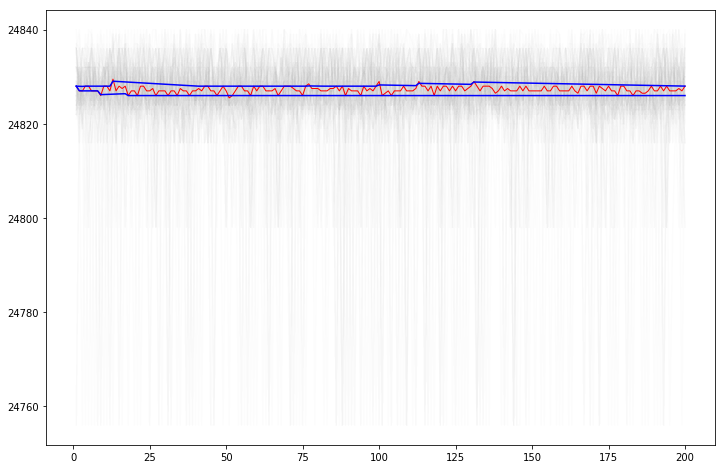

In [12]:

plt.figure(figsize=(12,8))
plt.plot(np.arange(1, n+1).reshape(n,1), solsamples, c='grey', alpha=0.02)
plt.plot(np.arange(1, n+1), solmedians, c='red', linewidth=1)
plt.plot(np.arange(1, n+1), upper, 'b', np.arange(1, n+1), lower, 'b');

## Confidence Interval of Other Statistics

The bootstrap is a fairly general technique. In the example below, we start by computing the 95% confidence interval for the 25% percentile estimate of the speed of light sample data (_e.g._ $P[Sol \leq x] = 0.25$).

However, the technique needs sufficient samples to estimate. What would happen if we computed the 95% confidence interval of the 10% percentile? The 99%?

In [19]:
reps = sol.size
n = 20
percentile=10
solsamples = np.random.choice(sol, (n, reps), replace=True)
solq1= np.percentile(solsamples,[percentile],axis=1)[0]
ul = np.array([ np.percentile(solq1[0:n+1],[2.5,97.5]) for n in range(solq1.size)])
upper, lower = ul.T
solq1[-1],upper[-1],lower[-1]

(24823.0, 24818.449999999997, 24823.262500000001)

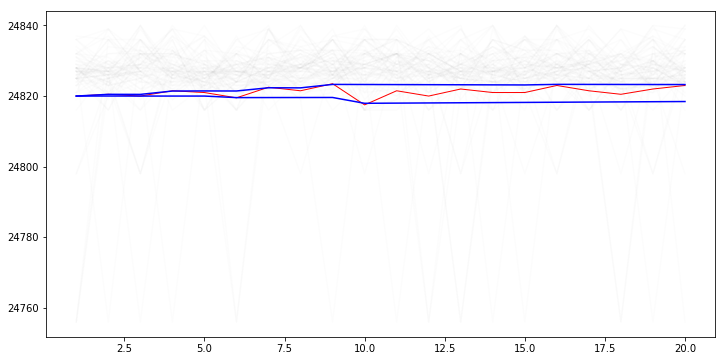

In [20]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(1, n+1).reshape(n,1), solsamples, c='grey', alpha=0.02)
plt.plot(np.arange(1, n+1), solq1, c='red', linewidth=1)
plt.plot(np.arange(1, n+1), upper, 'b', np.arange(1, n+1), lower, 'b');

## Parametric Bootstrap

In some cases, we strongly believe that some data, such as measurement errors, arise from a particular distribution. The speed-of-light data appears to be highly skewed by two low values, and if we remove those two samples, the data appears "more normal" as would be expected if measurement error is normally distributed.

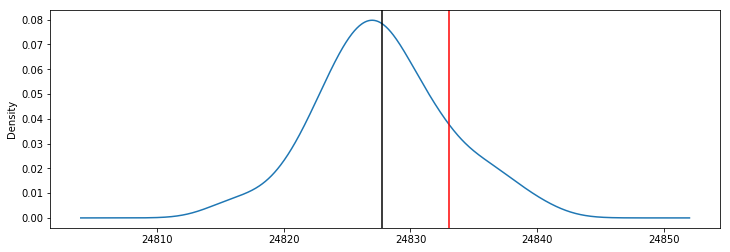

In [15]:
solclean =sol[ sol > 24800]
plt.figure(figsize=(12,4))
ssolclean = pd.Series(solclean)
ssolclean.plot.kde()
plt.axvline(x=np.mean(solclean),color='black')
plt.axvline(x=24833.02,color='r');

In this case, we can use a _parametric bootstrap_ to compute the confidence interval of statistics. In a parametric bootstrap, we would use samples from a distribution with parameters informed by our data. For example, if we believe that the speed of light measurement error is normally distributed, we would use the following algorithm:

```python
means = []
z=normal(sample mean, sample sd)
for a long time:
   sample = random samples from z
   means = means + mean(sample)
report the range containing 95% of the sample means
```

In [16]:
scmean, scsd = np.mean(solclean), np.std(solclean)
scmeans = ( [ np.mean( np.random.normal(scmean, scsd, sol.size) ) for x in range(1000) ] )
print ('We have', len(scmeans), 'means, some of which are ', scmeans[:3])

We have 1000 means, some of which are  [24827.251178339091, 24828.377769267361, 24828.246751008865]


In [17]:
scrange = np.percentile(scmeans, [2.5, 97.5])
print('Speed has mean', np.mean(sol), 'with lower CI', scrange[0], 'and upper CI', scrange[1])
print('CI is not symmetrical: lower', np.mean(solclean)-scrange[0], 'upper', scrange[1]-np.mean(solclean))

Speed has mean 24826.2121212 with lower CI 24826.571622 and upper CI 24828.9212583
CI is not symmetrical: lower 1.17837797865 upper 1.17125825655


## Why bother with parametric bootstrap?

We'll see that if you're trying to compute the confidence interval of data from a normal distribution there are other techniques that are more standard or common.

However, the bootstrap mechanism simplifies the computation of other statistics, such as the median, first quartile or others. Later, we'll see that the bootstreap is useful for estimating parameters or certainty of data or models for which there is no closed form.

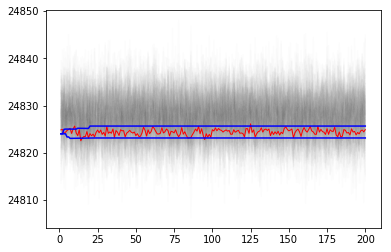

In [18]:
samps = solclean.size*2
n = 200
percentile=25
scsamples = ( [ np.random.normal(scmean, scsd, samps) for x in range(n) ] )
scq1= np.percentile(scsamples,[percentile],axis=1)[0]
ul = np.array([ np.percentile(solq1[0:n+1],[2.5,97.5]) for n in range(scq1.size)])
upper, lower = ul.T
plt.plot(np.arange(1, n+1).reshape(n,1), scsamples, c='grey', alpha=0.02)
plt.plot(np.arange(1, n+1), scq1, c='red', linewidth=1)
plt.plot(np.arange(1, n+1), upper, 'b', np.arange(1, n+1), lower, 'b');